# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification


### Transfer learning

In the previous notebook we have trained our own CNN and we got a certain performance. Let's see how hard it is to match that performance with transfer learning.

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 0: Setting up

The following cells make sure that your environment is setup correctly and check that your GPU is available and ready to go. You have to execute them every time you restart your notebook.

In [1]:
# Install requirements
!pip install -r requirements.txt | grep -v "already satisfied"

Defaulting to user installation because normal site-packages is not writeable


In [2]:
from src.helpers import setup_env

# If running locally, this will download dataset (make sure you have at 
# least 2 Gb of space on your hard drive)
setup_env()

GPU *NOT* available. Will use CPU (slow)
Dataset already downloaded. If you need to re-download, please delete the directory /data/DLND/C2/landmark_images
Reusing cached mean and std


---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 1: Create transfer learning architecture

Open the file `src/transfer.py` and complete the `get_model_transfer_learning` function. When you are done, execute this test:

In [3]:
!pytest -vv src/transfer.py

============================= test session starts ==============================
platform linux -- Python 3.7.6, pytest-7.1.1, pluggy-1.2.0 -- /opt/conda/bin/python3.7
cachedir: .pytest_cache
rootdir: /workspace/home
collected 1 item                                                               

src/transfer.py::test_get_model_transfer_learning PASSED                 [100%]

============================== 1 passed in 4.01s ===============================


---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 2: Train, validation and test

Let's train our transfer learning model! Let's start defining the hyperparameters:

In [4]:
from pathlib import Path
from src.helpers import get_data_location

# Define basic hyperparameters
batch_size = 6  # size of the minibatch
valid_size = 0.2  # fraction for validation
num_epochs = 50  # number of training epochs
learning_rate = 0.001  # learning rate
opt = 'adam'  # optimizer: 'sgd' or 'adam'
weight_decay = 0.0  # L2 regularization to combat overfitting

# Dynamically detect the number of classes from training directory
train_dir = Path(get_data_location()) / "train"
num_classes = len([d for d in train_dir.iterdir() if d.is_dir()])
print(f"🔢 Detected {num_classes} classes.")


🔢 Detected 50 classes.


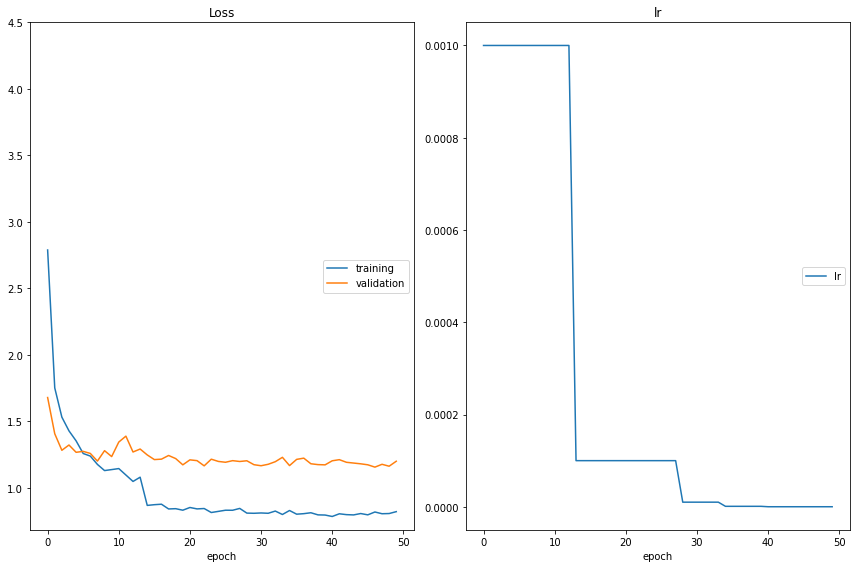

In [5]:
from src.data import get_data_loaders
from src.optimization import get_optimizer, get_loss
from src.train import optimize
from src.transfer import get_model_transfer_learning

# Get a model using get_model_transfer_learning. Use one of the names reported here:
# https://pytorch.org/vision/0.10/models.html
# For example, if you want to load ResNet 18, use "resnet18"
# NOTE: use the hyperparameters defined in the previous cell, do NOT copy/paste the
# values
model_transfer = get_model_transfer_learning("resnet18", n_classes=num_classes)

# train the model
data_loaders = get_data_loaders(batch_size=batch_size)
optimizer = get_optimizer(
    model_transfer,
    learning_rate=learning_rate,
    optimizer=opt,
    weight_decay=weight_decay,
)
loss = get_loss()

optimize(
    data_loaders,
    model_transfer,
    optimizer,
    loss,
    n_epochs=num_epochs,
    save_path="checkpoints/model_transfer.pt",
    interactive_tracking=True
)

<img src="static_images/icons/noun-question-mark-869751.png" alt="?" style="width:25px"/> __Question:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__  
For this task, I used the **ResNet18** architecture from `torchvision.models`. This model is pretrained on ImageNet, allowing us to transfer learned features from a large-scale dataset.

Key reasons for this choice:
- **Generalization**: Pretrained models have already learned low-level visual features (edges, corners, textures) and can generalize well to similar tasks.
- **Speed & Efficiency**: Freezing most layers and only training the final classifier significantly reduces training time.
- **Suitability**: ResNet18 has a relatively small number of parameters, making it ideal for faster experimentation and avoiding overfitting.

We freeze all backbone layers and only update the final fully connected layer, which we replace to output the correct number of landmark classes (`n_classes`). This setup uses transfer learning effectively while tailoring the output to our dataset.


Now play with the hyperparameters and see which performance you can get on the validation set. You should get at least 60% for a passing grade, but a good model choice and a good training strategy could get you up to 80% or so. Let's see how close you can get!

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 3: Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60% and matches more or less what you got on the validation set (otherwise you're overfitting!)

In [6]:
import torch
from src.train import one_epoch_test
from src.transfer import get_model_transfer_learning

model_transfer = get_model_transfer_learning("resnet18", n_classes=num_classes)
# Load saved weights
model_transfer.load_state_dict(torch.load('checkpoints/model_transfer.pt'))

one_epoch_test(data_loaders['test'], model_transfer, loss)

Testing: 100%|████████████████████████████████| 209/209 [04:16<00:00,  1.23s/it]


📊 Test Loss: 1.024076
✅ Test Accuracy: 75.52% (944/1250)


1.0240758351094807

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 4: Export using torchscript

Now, just like we did with our original model, we export the best fit model using torchscript so that it can be used in our application:

In [7]:
from src.predictor import Predictor
from src.helpers import compute_mean_and_std

# First let's get the class names from our data loaders
class_names = data_loaders["train"].dataset.classes

# Then let's move the model_transfer to the CPU
# (we don't need GPU for inference)
model_transfer = model_transfer.cpu()
# Let's make sure we use the right weights by loading the
# best weights we have found during training
# NOTE: remember to use map_location='cpu' so the weights
# are loaded on the CPU (and not the GPU)
model_transfer.load_state_dict(
    torch.load("checkpoints/model_transfer.pt", map_location="cpu")
)

# Let's wrap our model using the predictor class
mean, std = compute_mean_and_std()
predictor = Predictor(model_transfer, class_names, mean, std).cpu()

# Export using torch.jit.script
scripted_predictor = torch.jit.script(predictor)
scripted_predictor.save("checkpoints/transfer_exported.pt")

Reusing cached mean and std


100%|███████████████████████████████████████| 1250/1250 [04:56<00:00,  4.21it/s]


Accuracy: 0.7344


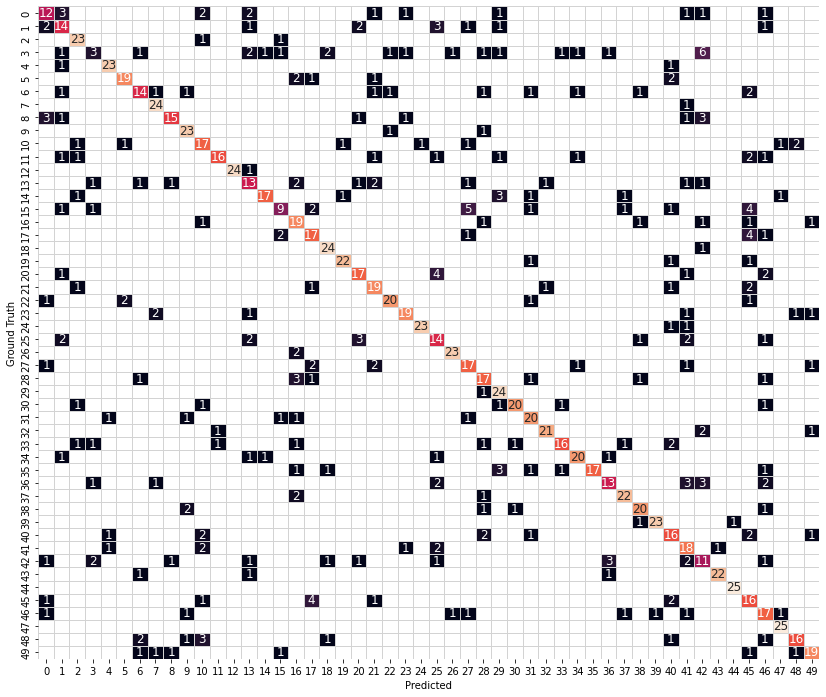

In [8]:
import torch
from src.predictor import predictor_test
from src.helpers import plot_confusion_matrix

model_reloaded = torch.jit.load("checkpoints/transfer_exported.pt")

pred, truth = predictor_test(data_loaders['test'], model_reloaded)

plot_confusion_matrix(pred, truth)


In [ ]:

from src.helpers import get_data_location
from src.data import get_data_loaders
from src.optimization import get_optimizer, get_loss
from src.train import optimize, one_epoch_test
from src.transfer import get_model_transfer_learning
from pathlib import Path
import torch

# Hyperparameters
batch_size = 16
valid_size = 0.2
num_epochs = 10
learning_rate = 0.0008
weight_decay = 1e-4
opt = 'adam'

# Dynamically get number of classes
train_path = Path(get_data_location()) / "train"
num_classes = len([f for f in train_path.iterdir() if f.is_dir()])
print(f"Detected {num_classes} classes")

# Load data
data_loaders = get_data_loaders(batch_size=batch_size, valid_size=valid_size, num_workers=0)

# Load transfer learning model
model_transfer = get_model_transfer_learning("resnet18", n_classes=num_classes)

# Optimizer and loss
optimizer = get_optimizer(model_transfer, optimizer=opt, learning_rate=learning_rate, weight_decay=weight_decay)
loss = get_loss()

# Train the model
optimize(
    data_loaders,
    model_transfer,
    optimizer,
    loss,
    n_epochs=num_epochs,
    save_path="checkpoints/model_transfer.pt",
    interactive_tracking=True
)

# Evaluate the trained model on the test set
print("\nEvaluating model on test set...")
model_transfer.load_state_dict(torch.load("checkpoints/model_transfer.pt"))
one_epoch_test(data_loaders["test"], model_transfer, loss)
